# Building population density suitablity layers for GRIDCERF

## 1. Downloading the data

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.

GRIDCERF provides mosaicked CONUS-scale population rasters for 5-year intervals from 2020 through 2100 for three Shared Socioeconomic Pathways (SSPs):  SSP2, SSP3, and SSP5.

### 1.2 Data Description

- **Title**:  Data Supplement: U.S. state-level projections of the spatial distribution of population consistent with Shared Socioeconomic Pathways.
- **Description from Source**:   U.S. state-level projections of the spatial distribution of population consistent with Shared Socioeconomic Pathways.
- **Source URL**:  https://doi.org/10.5281/zenodo.3756179
- **Date Accessed**:  11/3/21
- **Citation**
> Zoraghein, H., & O'Neill, B. (2020). Data Supplement: U.S. state-level projections of the spatial distribution of population consistent with Shared Socioeconomic Pathways. (v0.1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3756179
- **Application**: Three different population-density based suitability rasters are built from this notebook: population-dense areas with no buffer, population-dense areas with a 25 mile buffer, and a nuclear-specific population density layer. Each are described below.
    * <b> Population-dense (no buffer): </b> Any 25-square mile circle and all inclusive area is considered unsuitable for siting (value=1) if the population within that circular area is greater than or equal to 50,000 people
    * <b> Population-dense (25-mile buffer): </b> Any 25-square mile circle, all inclusive area is considered unsuitable for siting (value=1) if the population within the circular area is greater than or equal to 50,000 people. All area within 25 miles of unsuitable areas is also considered unsuitable for siting.
    * <b> Population-dense (Nuclear specific): </b> Siting nuclear reactors requires specific population-density based metrics. Using a singular grid-cell as a starting point, any circle drawn around that point, up to a 20-mile radius, is excluded as unsuitable if the average population <i> density </i> within that circle is greater than or equal to 500 people per square mile. To avoid offshore areas with population of 0 decreasing the average for coastal areas, offshore areas are considered to have null population and are not included in the average for any circle that includes offshore areas.

## 2. Setup environment

### 2.1 Import necessary Python packages

In [1]:
import os
import glob
import math

import rasterio
import numpy as np
import warnings
from typing import List, Callable

import dask.array as da
import numpy as np
import rasterio
from dask.distributed import Client
from rasterio.plot import show
from rasterio.features import shapes
from rasterio.transform import Affine
from scipy.ndimage import generic_filter, distance_transform_edt
from tqdm import tqdm


### 2.2 Suppress Warnings

In [2]:
# filter out the UserWarning raised by Dask for sending large graphs
warnings.filterwarnings(
    "ignore", 
    message="Sending large graph of size .*", 
    category=UserWarning
)

# filter out the RuntimeWarning raised by NumPy for taking a nanmean of an all nan window
warnings.filterwarnings(
    "ignore", 
    message="Mean of empty slice", 
    category=RuntimeWarning
)


## 3. Configuration

In [3]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF technology specific source data directory
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "population")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF scenario specific data directory
scenario_specific_dir = os.path.join(gridcerf_dir, "scenario_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template land mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# gridcerf land mask raster
gridcerf_landmask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# list of ssp scenarios to create rasters for
ssp_list = ['ssp2', 'ssp3', 'ssp5']

# list of years to create rasters for
year_list = list(range(2020, 2101, 5))

## 4. Generate population rasters

### 4.1 Functions

In [4]:
def generate_km_buffers(
    through_mile: int, 
    mile_interval: int, 
    mi_to_km_conversion: float
) -> List[int]:
    """
    Generate a list of km buffers for mile designations, rounding up to the nearest km.

    :param through_mile: The ending mile buffer.
    :param mile_interval: The interval between mile buffers.
    :param mi_to_km_conversion: The conversion factor from miles to kilometers.
    :return: A list of km buffers.
    """
    start_mile = 1
    
    km_buffer_list = [
        np.ceil(mile * mi_to_km_conversion).astype(np.uint8) for mile in range(
            start_mile, through_mile + mile_interval, mile_interval
        )
    ]

    # add in 0 and 1 km buffers since they are less than a mile
    additional_radii = [0, 1]

    return additional_radii + km_buffer_list


def window_average(window: np.ndarray, people_per_sqmi: int = 500) -> bool:
    """
    Determine if the average population within a window meets or exceeds a threshold.

    This function calculates the mean population count within a specified window (array of values)
    and determines if it is greater than or equal to a given threshold value, which is
    defined in terms of people per square mile and converted to people per square kilometer.

    :param window: The array of population counts for each cell within the window.
    :type window: array_like
    :param people_per_sqmi: The population threshold per square mile to compare against the average population within the window, defaults to 500.
    :type people_per_sqmi: int, optional
    :returns: True if the average population is greater than or equal to the threshold when converted to people per square kilometer, otherwise False.
    :rtype: bool
    """
    # square miles to square kilometers conversion factor
    sqmi_to_sqkm = 2.58999
    
    # convert people per square mile to people per square kilometer
    threshold = people_per_sqmi / sqmi_to_sqkm
    
    return np.nanmean(window) >= threshold


def window_sum(window: np.ndarray, population: int = 50000) -> bool:
    """
    Determine if the average population within a window meets or exceeds a threshold.

    This function calculates the population sum within a specified window (array of values)
    and determines if it is greater than or equal to a given threshold value, which is
    defined in terms of number of people.

    :param window: The array of population counts for each cell within the window.
    :type window: array_like
    :param population: The population threshold within the window, defaults to 50000.
    :type population: int, optional
    :returns: True if the population sum is greater than or equal to the threshold, otherwise False.
    :rtype: bool
    """
    
    return np.nansum(window) >= population


def apply_selection_filter(
    dask_array: da.Array, 
    radius: int, 
    function: Callable
) -> da.Array:
    """
    Apply a custom filter to a Dask array to reclassify population data.

    This function calculates the desired population statistic per grid cell and its surrounding
    buffer based on a specified radius. It then reclassifies the result into a binary
    format where cells with a non-zero average population are marked as 1, and others
    as 0.

    :param dask_array: The Dask array containing population data.
    :type dask_array: dask.array.Array
    :param radius: The radius of the buffer around each grid cell to consider for the average calculation.
    :type radius: int
    :param function: The function to apply over the dask array.
    :type function: Callable
    :returns: A binary Dask array where each cell is 1 if the population statistic in the buffer is non-zero, otherwise 0.
    :rtype: dask.array.Array
    """
    # calculate the size of the window to apply the function over
    window_size = 2 * radius + 1

    # apply a custom filter function over the dask array with a specified window size
    # the filter function will compute the population statistic within the window
    filter_result = dask_array.map_overlap(
        generic_filter,
        depth={0: radius, 1: radius},
        boundary='none',
        function=function,
        size=(window_size, window_size)
    )

    # convert the filter result to a binary array: 1 if population statistic is non-zero, otherwise 0
    binary_result = (filter_result > 0).astype(int)
    
    return binary_result


def process_radius(
    dask_array: da.Array, 
    km_radius: int,
    template_land_mask: np.ndarray,
    function: Callable
) -> da.Array:    
    """
    Process a Dask array for a given radius and compute the result.

    This function applies a selection filter to a Dask array based on the specified
    kilometer radius. It computes the result of the filtering, which involves
    calculating the population statistic per grid cell and its surrounding buffer.
    The result is then computed to get the final array. Additionally, a land mask
    can be applied to the result to mask out non-land areas.

    :param dask_array: The Dask array containing population data.
    :type dask_array: dask.array.Array
    :param km_radius: The radius in kilometers for the buffer around each grid cell.
    :type km_radius: int
    :param template_land_mask: A boolean array representing the land mask to be applied. 1==land, 0==non-land.
    :type template_land_mask: np.ndarray
    :param function: The function to apply over the dask array.
    :type function: Callable
    :returns: A Dask array with the computed result after applying the selection filter.
    :rtype: dask.array.Array
    """

    result = apply_selection_filter(dask_array, km_radius, function)
    
    # compute the result array from the Dask computation graph
    result_array = result.compute()

    # apply the land mask and convert NaN to unsuitable (1)
    result_array = result_array.astype(np.float64)
    result_array *= template_land_mask
    result_array = np.where(np.isnan(result_array), 1, result_array).astype(np.int16)

    return result_array


def combine_radii(
    radii_dict: dict, 
    input_population_file: str, 
    output_population_dir: str, 
    template_profile: dict
) -> None:
    """
    Combine radius arrays and write the result to a binary raster file.

    This function takes a dictionary of radius arrays, combines them by summing up,
    and reclassifies the combined array into a binary format. The binary format
    represents suitability, where 1 indicates unsuitable and 0 indicates suitable.
    The result is then written to a raster file with the name constructed from the
    input file's basename appended with "_nuclear.tif".

    :param radii_dict: Dictionary of radius arrays to combine.
    :type radii_dict: dict
    :param input_population_file: Path to the input population file.
    :type input_population_file: str
    :param output_population_dir: Directory where the output file will be saved.
    :type output_population_dir: str
    :param template_profile: Rasterio profile with metadata for writing the output file.
    :type template_profile: dict
    """
    # combine all arrays from the radii
    for index, i in enumerate(radii_dict.keys()):

        if index == 0:
            output_array = radii_dict[i]
        else:
            output_array += radii_dict[i]

    # reclassify output array to be binary where 1 is unsuitable and 0 is suitable
    output_array = np.where(output_array >= 1, 1, 0).astype(np.int16)

    # construct output file path name
    basename = os.path.splitext(os.path.basename(input_population_file))[0]
    basename += f"_nuclear.tif"
    output_population_file = os.path.join(output_population_dir, basename)

    with rasterio.open(gridcerf_landmask) as land_area:
            land_array = land_area.read(1)

    # multiple input raster by land area to change offshore areas to 0 
    result_array *= land_array

    # multiply by siting mask
    with rasterio.open(template_raster) as siting_mask:
        siting_area = siting_mask.read(1) # Read first band

    # convert the land portion of the siting area to np.nan
    siting_area = np.where(siting_area == 1, np.nan, 1).astype(np.int16)

    # mask by siting area
    result_array += siting_area
    result_array = np.where(result_array>1, 1, result_array)

    # write output raster
    with rasterio.open(output_population_file, "w", **template_profile) as dest:
        dest.write(output_array, 1)

def adjust_raster_extent(ssp, year):
    """
    Warps source population data to GRIDCERF extent and fills in extended area with population of 0.

    :param ssp: socioeconomic pathway
    :type ssp: str
    :param year: population year
    :type year: int
    """
    
    input_tif = os.path.join(source_dir, f'gridcerf_population_{ssp}_{year}_1km_conus.tif')
    output_raster_dir = os.path.join(source_dir, 'warped')
    os.makedirs(output_raster_dir, exist_ok=True), 
    output_raster = os.path.join(output_raster_dir, f'gridcerf_population_{ssp}_{year}_1km_conus.tif')
    
    # warp the input and save to tmp output
    gdal_warp_cmd = f"gdalwarp -te -2831615.228 -1539013.3223 2628318.0948 1690434.1707 -tr 1000.0 1000.0 -overwrite {input_tif} {output_raster}"
    os.system(gdal_warp_cmd)
      
    return None



### 4.2 Adjust Extent of Source Population Data

Reads in source population data, extends it, and saves to a new "warped" folder in the source data directory.

In [ ]:
for ssp in ssp_list:
    for year in year_list:
        adjust_raster_extent(ssp=ssp, year=year)

### 4.3 Generate the population files on a year by year basis

In [5]:
# read in the template land mask where land == 1 and non-land == 0
with rasterio.open(gridcerf_landmask) as template:
    template_profile = template.profile.copy()
    template_land_mask = template.read(1).copy()
    
    # make non-land NaN
    template_land_mask = np.where(template_land_mask == 0, np.nan, template_land_mask)

#### 4.3.1 Nuclear-Specific
Average people per square mile for 1-mile through 20-mile radius circles around the center of the grid cell. Any of those circles that have an average of 500 people per square mile are excluded.

##### Settings

In [29]:
# choice to write individual radius rasters
write_radius_raster = False

# conversion from mi to km
mi_to_km = 1.60934

# through mile buffers with the interval
through_mile_buffer = 20
mile_buffer_interval = 1

# optimal chunk size for a four processor setup with 16 GB RAM
chunk_size = (411, 637)

In [30]:
# convert mile buffers to kilometer buffers for processing
km_buffers = generate_km_buffers(through_mile_buffer, mile_buffer_interval, mi_to_km)

In [16]:
def create_nuclear_pop(input_population_file, output_raster_dir):
    # process a population raster file
    with rasterio.open(input_population_file) as src:
    
        # read in raster as an array
        raster_array = src.read(1)
    
        # replace the raster nodata value with NaN
        raster_array = np.where(raster_array == src.nodata, np.nan, raster_array)
        
        # convert the raster data to a Dask array and chunk it
        dask_array = da.from_array(
            raster_array, 
            chunks=chunk_size
        )  
    
        # dictionary to store individual radius arrays
        radii_dict = {}
    
        # process each buffer
        for mi_radius, km_radius in enumerate((pbar := tqdm(km_buffers)), 1):
            
            pbar.set_description(f"Processing {km_radius} km radius")
        
            # apply the radius buffer and generate a binary numpy array
            result_array = process_radius(
                dask_array=dask_array, 
                km_radius=km_radius,
                template_land_mask=template_land_mask,
                function=window_average
            )
    
            # store result
            radii_dict[km_radius] = result_array
    
            if write_radius_raster:
    
                # construct output file path name
                basename = os.path.splitext(os.path.basename(input_population_file))[0]
                basename += f"_nuclear-{km_radius}km-radius.tif"
                output_population_file = os.path.join(output_raster_dir, basename)
    
                # write output raster
                with rasterio.open(output_population_file, "w", **template_profile) as dest:
                    dest.write(result_array, 1)
    
    
        # combine all radii into a single output file
        combine_radii(radii_dict=radii_dict, input_population_file=input_population_file, 
                      output_population_dir=output_population_dir, template_profile=template_profile)


##### Create Nuclear Population Rasters

In [ ]:
%%time
for ssp in ssp_list:
    for year in year_list:
        input_population_file = os.path.join(source_dir, 'warped', f'gridcerf_population_{ssp}_{year}_1km_conus.tif')
        create_nuclear_pop(input_population_file=input_population_file, output_raster_dir=scenario_specific_dir)

##### Mask by full siting extent

In [ ]:
%%time
for ssp in ssp_list:
    for year in year_list:

        input_population_file =  os.path.join(scenario_specific_dir, f'gridcerf_population_{ssp}_{year}_1km_conus_nuclear.tif')

        result_array = rasterio.open(input_population_file).read(1)
        
        with rasterio.open(gridcerf_landmask) as land_area:
            land_array = land_area.read(1)
            meta = land_area.meta
            
        # multiply input raster by land area to change offshore areas to 0 
        result_array *= land_array
        
        # multiply by siting mask
        with rasterio.open(template_raster) as siting_mask:
            siting_area = siting_mask.read(1) # Read first band
        
        # convert the land portion of the siting area to np.nan
        siting_area = np.where(siting_area == 1, np.nan, 1).astype(np.int16)
        
        # mask by siting area
        result_array += siting_area
        result_array = np.where(result_array>1, 1, result_array)
        
        show(result_array)
        
        # Write the new buffered raster to file
        with rasterio.open(input_population_file, 'w', **meta) as dst:
            dst.write(result_array, 1)

#### 4.3.2 Unbuffered population-dense areas
Any area of at least 25 square miles that has 50,000 inhabitants or greater

##### Settings

In [11]:
# square miles to square kilometers conversion factor
sqmi_to_sqkm = 2.58999

# miles to kilometers conversion factor
mi_to_km = 1.60934

# people threshold within 25 square miles
people_per_area = 50000

# area of window in square miles
window_area = 25

# radius in miles
mi_radius = np.sqrt(window_area).astype(np.int64)

# radius in km
km_radius = np.ceil(mi_radius * mi_to_km).astype(np.int64)

# optimal chunk size for a four processor setup with 16 GB RAM
chunk_size = (411, 637)

In [12]:
def create_pop_raster(input_population_file, output_raster_dir):
    # process a population raster file
    with rasterio.open(input_population_file) as src:
    
        # read in raster as an array
        raster_array = src.read(1)
    
        # replace the raster nodata value with NaN
        raster_array = np.where(raster_array == src.nodata, np.nan, raster_array)
        
        # convert the raster data to a Dask array and chunk it
        dask_array = da.from_array(
            raster_array, 
            chunks=chunk_size
        )
    
        # apply the radius buffer and generate a binary numpy array
        result_array = process_radius(
            dask_array=dask_array, 
            km_radius=km_radius,
            template_land_mask=template_land_mask,
            function=window_sum
        )

        with rasterio.open(gridcerf_landmask) as land_area:
            land_array = land_area.read(1)

        # multiple input raster by land area to change offshore areas to 0 
        result_array *= land_array

        # multiply by siting mask
        with rasterio.open(template_raster) as siting_mask:
            siting_area = siting_mask.read(1) # Read first band
    
        # convert the land portion of the siting area to np.nan
        siting_area = np.where(siting_area == 1, np.nan, 1).astype(np.int16)
    
        # mask by siting area
        result_array += siting_area
        result_array = np.where(result_array>1, 1, result_array)

        # construct output file path name
        basename = os.path.splitext(os.path.basename(input_population_file))[0]
        basename += f"_{int(people_per_area/1000)}k_per{window_area}sqmi.tif"
        output_population_file = os.path.join(output_raster_dir, basename)
    
        # write output raster
        with rasterio.open(output_population_file, "w", **template_profile) as dest:
            dest.write(result_array, 1)


##### Create unbuffered population density rasters

In [13]:
%%time
for ssp in ssp_list:
    for year in year_list:
        print(ssp, year)
        input_population_file = os.path.join(source_dir, 'warped', f'gridcerf_population_{ssp}_{year}_1km_conus.tif')
        create_pop_raster(input_population_file=input_population_file, output_raster_dir=scenario_specific_dir)

ssp2 2020
ssp2 2025
ssp2 2030
ssp2 2035
ssp2 2040
ssp2 2045
ssp2 2050
ssp2 2055
ssp2 2060
ssp2 2065
ssp2 2070
ssp2 2075
ssp2 2080
ssp2 2085
ssp2 2090
ssp2 2095
ssp2 2100
ssp3 2020
ssp3 2025
ssp3 2030
ssp3 2035
ssp3 2040
ssp3 2045
ssp3 2050
ssp3 2055
ssp3 2060
ssp3 2065
ssp3 2070
ssp3 2075
ssp3 2080
ssp3 2085
ssp3 2090
ssp3 2095
ssp3 2100
ssp5 2020
ssp5 2025
ssp5 2030
ssp5 2035
ssp5 2040
ssp5 2045
ssp5 2050
ssp5 2055
ssp5 2060
ssp5 2065
ssp5 2070
ssp5 2075
ssp5 2080
ssp5 2085
ssp5 2090
ssp5 2095
ssp5 2100
CPU times: user 1h 27min 1s, sys: 2h 48min 22s, total: 4h 15min 23s
Wall time: 1h 47min 39s


#### 4.3.3 Buffered population-dense areas
Any area of at least 25 square miles that has 50,000 inhabitants or greater buffered by 25 miles.

**NOTE**:  This code takes the output of the densely populated areas from above as an input

##### Settings

In [12]:

mi_buffer = 25

# conversion from mi to km
mi_to_km = 1.60934

# buffer in kilometers
km_buffer = mi_buffer * mi_to_km

# buffer distance in miles
buffer_distance_miles = 25

In [28]:
def buffer_raster(input_raster_file, output_raster_dir, buffer_distance_mi):

    # construct output file path name
    basename = os.path.splitext(os.path.basename(input_raster_file))[0]
    basename += f"_{buffer_distance_mi}buffer.tif"
    output_raster_file = os.path.join(output_raster_dir, basename)

    # Read the input raster file
    with rasterio.open(input_raster_file) as src:
        data = src.read(1)  # Read first band
        meta = src.meta

    with rasterio.open(gridcerf_landmask) as land_area:
        land_array = land_area.read(1)

    # multiple input raster by land area to change offshore areas to 0 
    data *= land_array

    # Convert buffer distance from miles to kilometers (1 mile = 1.60934 km)
    buffer_distance_km = buffer_distance_mi * 1.60934

    # Create a mask for unsuitable grid cells (value = 1)
    mask_unsuitable = data == 1

    # Compute the Euclidean distance for each cell to the nearest unsuitable cell
    distance = distance_transform_edt(~mask_unsuitable) # * src.res[0]  # multiplying by resolution to get distance in km

    # Buffer by the specified distance
    buffered = distance <= buffer_distance_km

    # Update data with buffered unsuitable areas
    data[buffered] = 1

    # multiply by siting mask
    with rasterio.open(template_raster) as siting_mask:
        siting_area = siting_mask.read(1) # Read first band

    # convert the land portion of the siting area to np.nan
    siting_area = np.where(siting_area == 1, np.nan, 1).astype(np.int16)

    # mask by siting area
    data += siting_area
    data = np.where(data>1, 1, data)

    show(data)
    
    # Write the new buffered raster to file
    with rasterio.open(output_raster_file, 'w', **meta) as dst:
        dst.write(data, 1)


##### Create buffered population rasters

ssp2 2020


/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_82605/4190576628.py:38: RuntimeWarning: invalid value encountered in cast
  siting_area = np.where(siting_area == 1, np.nan, 1).astype(np.int16)


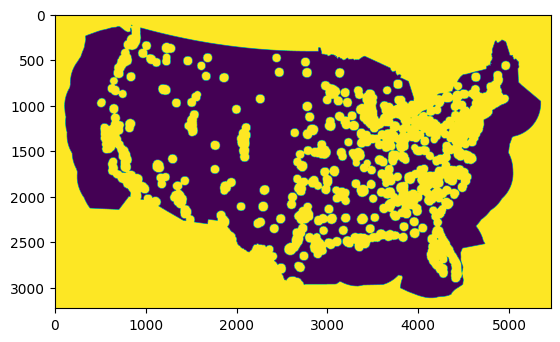

ssp2 2025


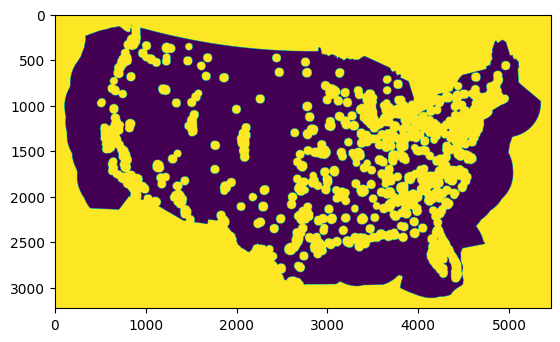

ssp2 2030


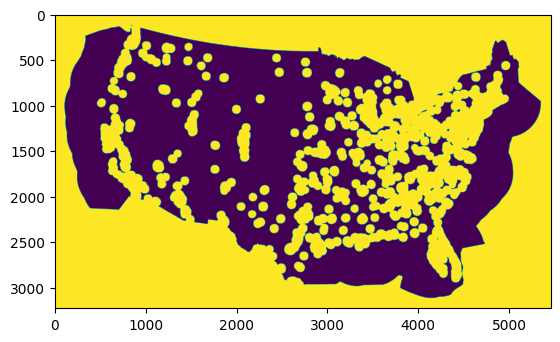

ssp2 2035


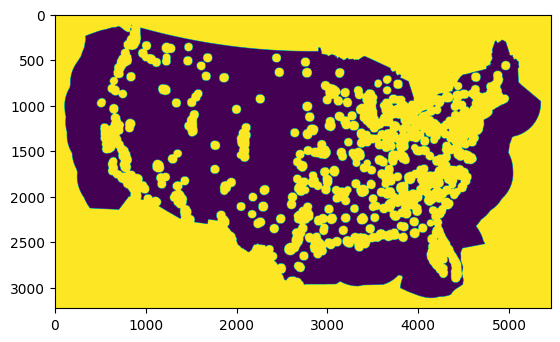

ssp2 2040


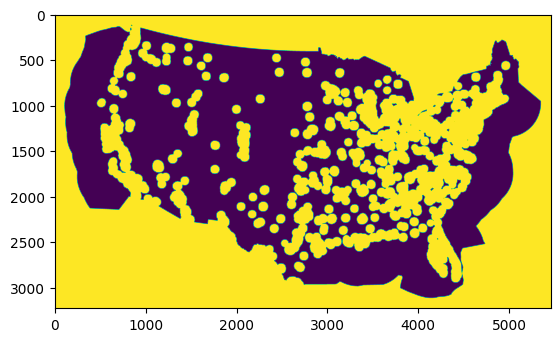

ssp2 2045


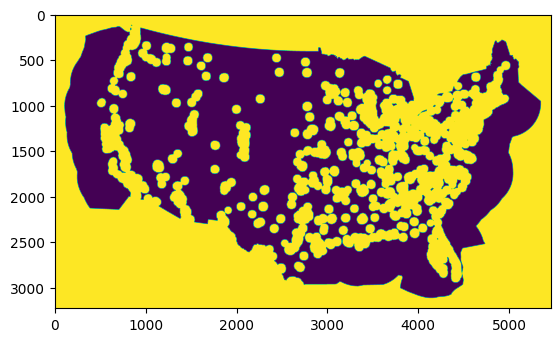

ssp2 2050


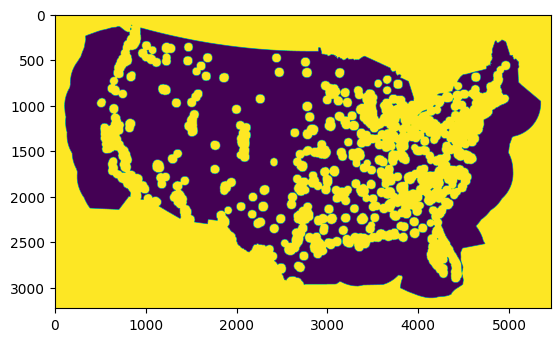

ssp2 2055


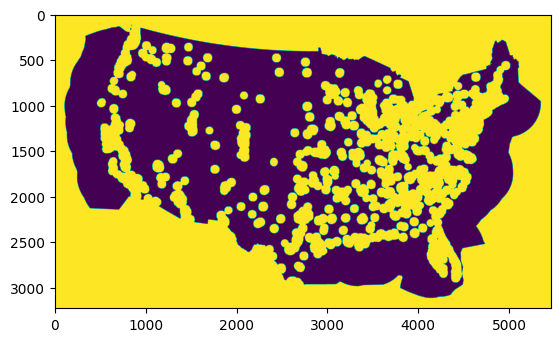

ssp2 2060


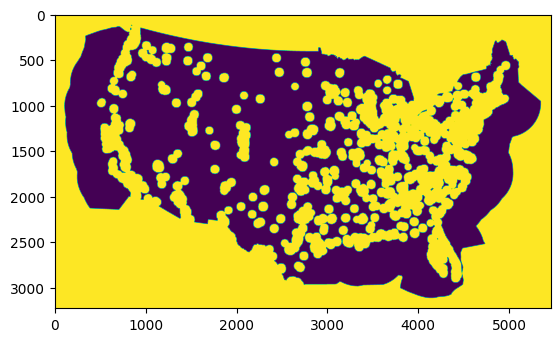

ssp2 2065


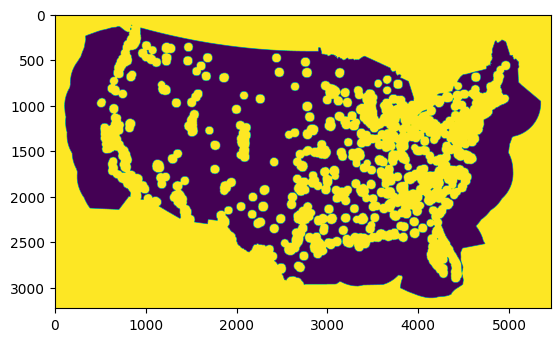

ssp2 2070


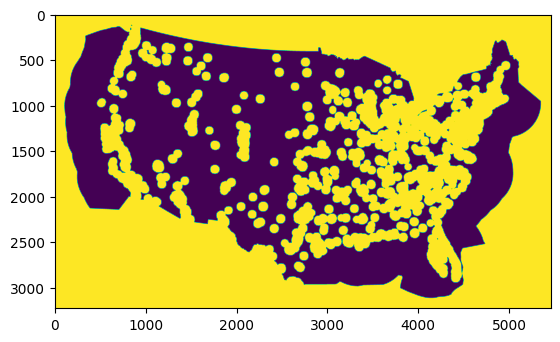

ssp2 2075


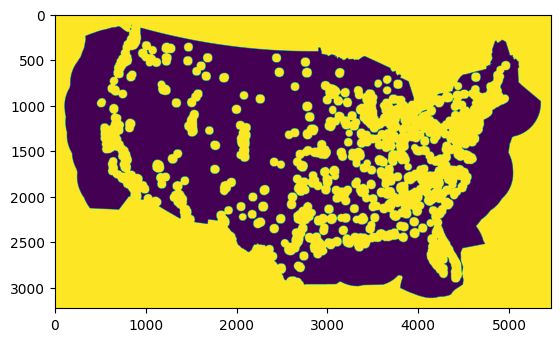

ssp2 2080


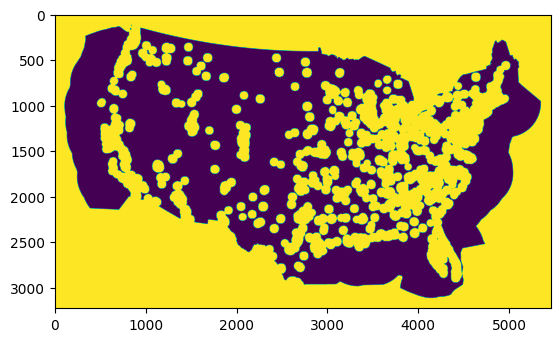

ssp2 2085


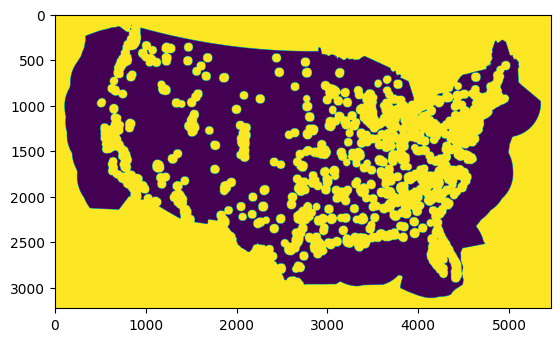

ssp2 2090


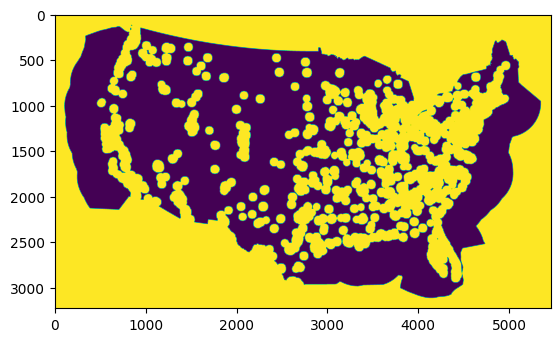

ssp2 2095


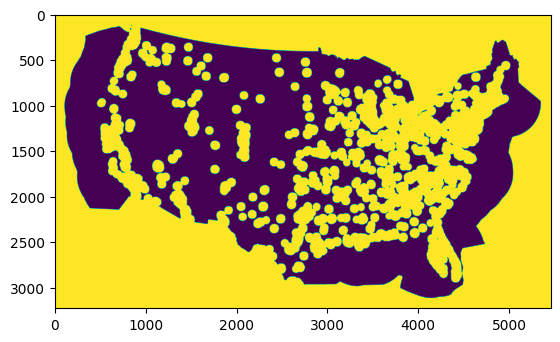

ssp2 2100


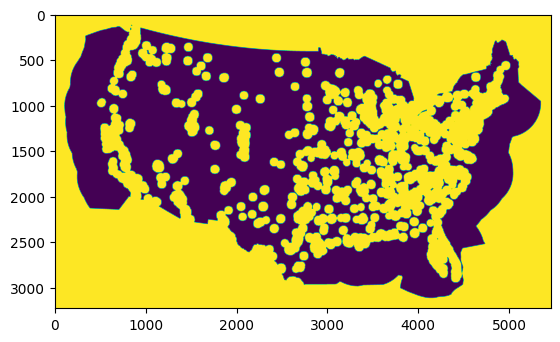

ssp3 2020


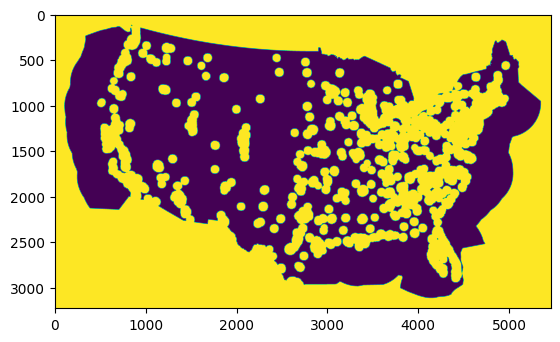

ssp3 2025


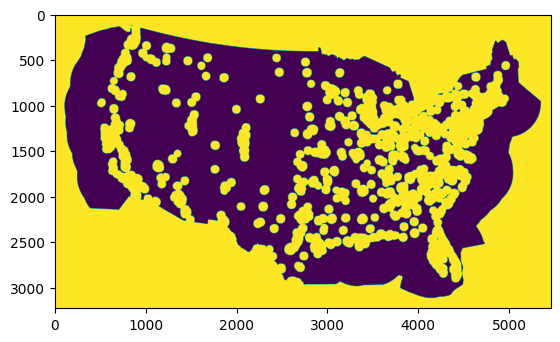

ssp3 2030


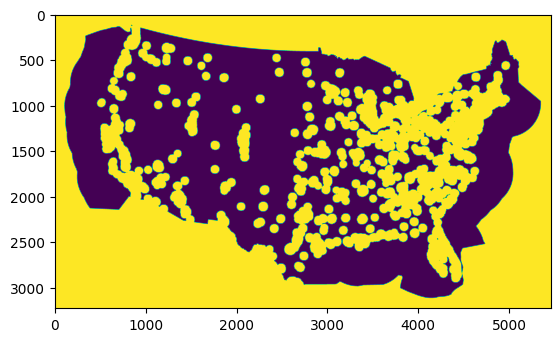

ssp3 2035


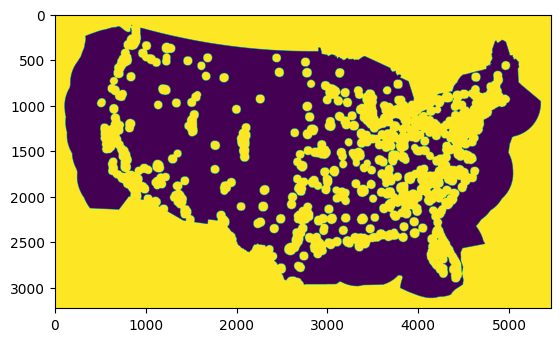

ssp3 2040


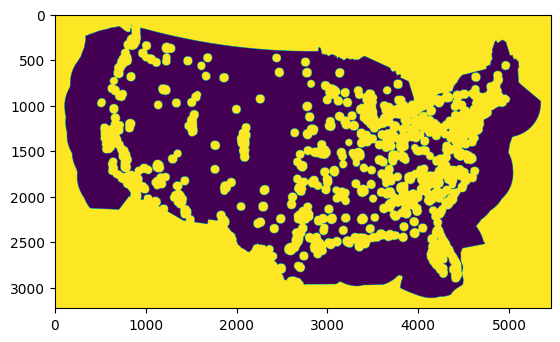

ssp3 2045


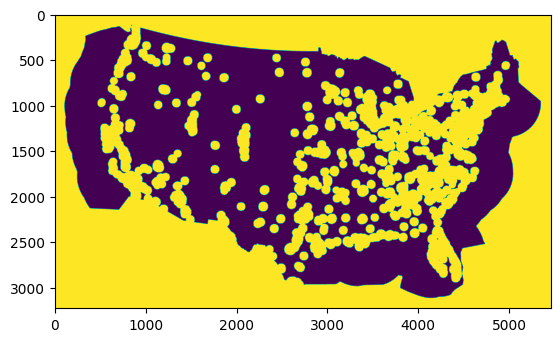

ssp3 2050


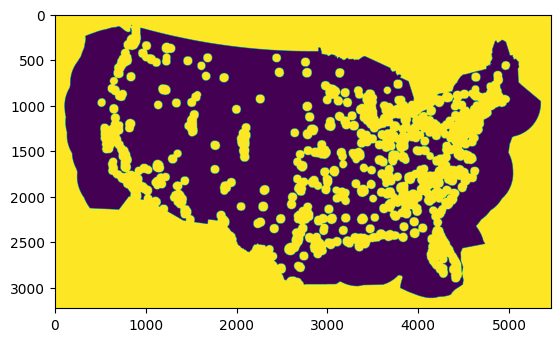

ssp3 2055


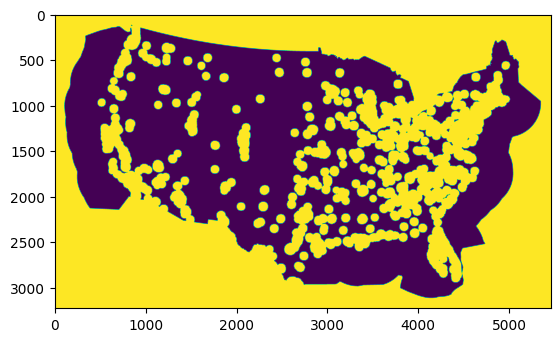

ssp3 2060


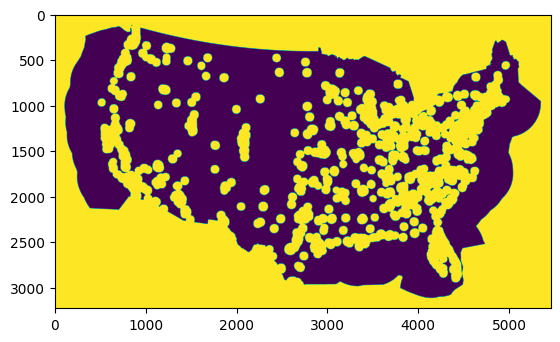

ssp3 2065


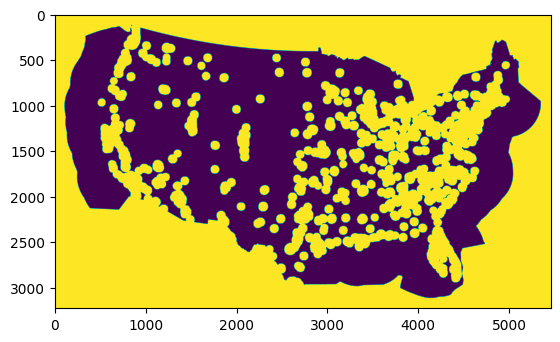

ssp3 2070


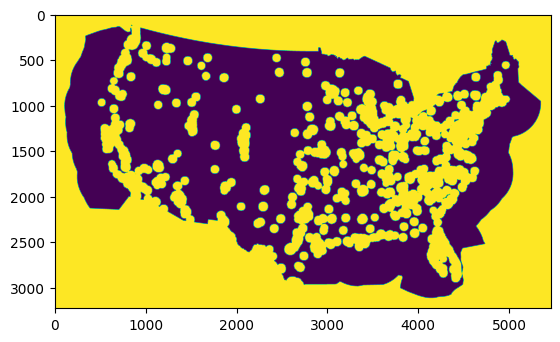

ssp3 2075


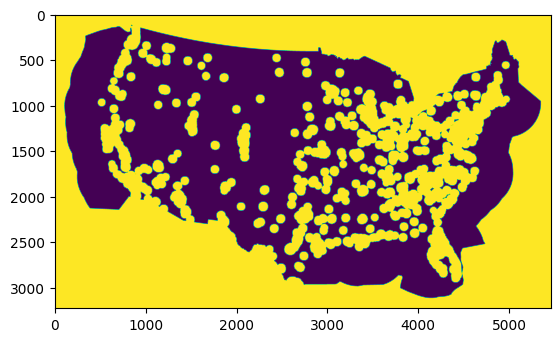

ssp3 2080


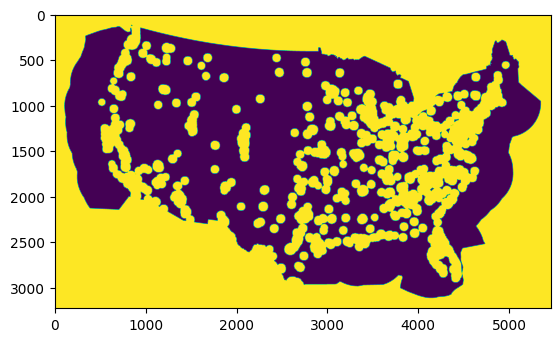

ssp3 2085


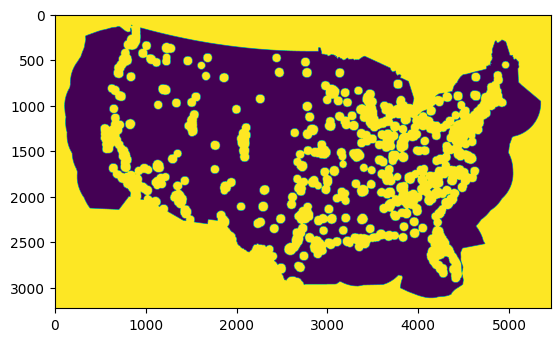

ssp3 2090


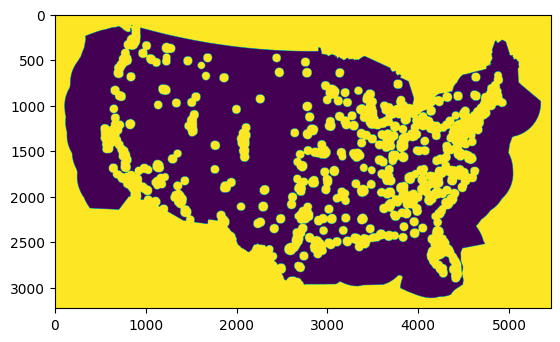

ssp3 2095


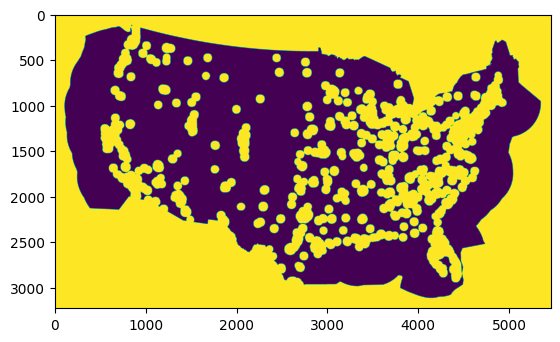

ssp3 2100


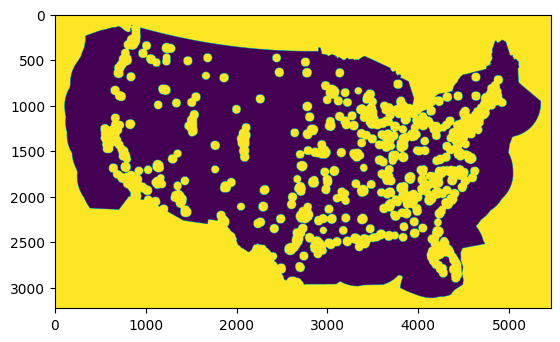

ssp5 2020


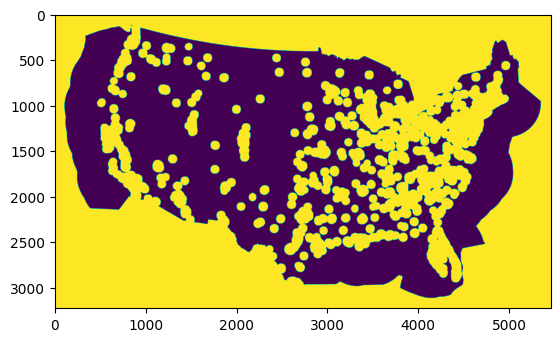

ssp5 2025


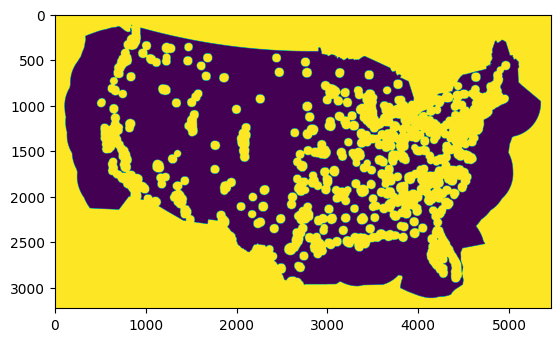

ssp5 2030


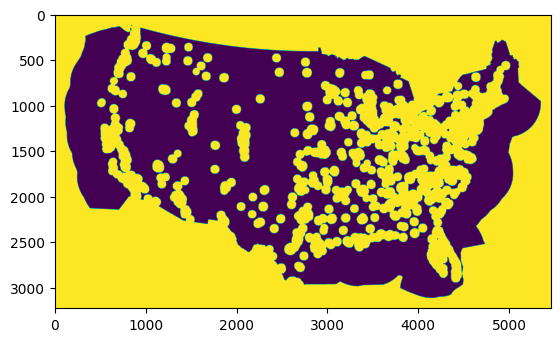

ssp5 2035


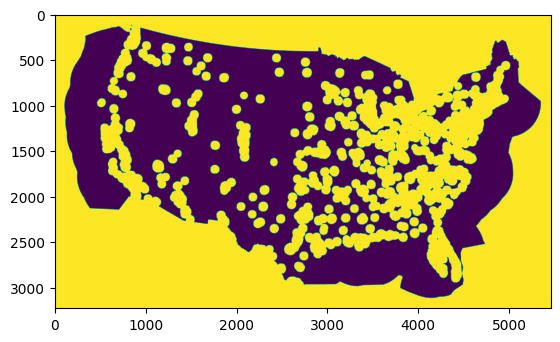

ssp5 2040


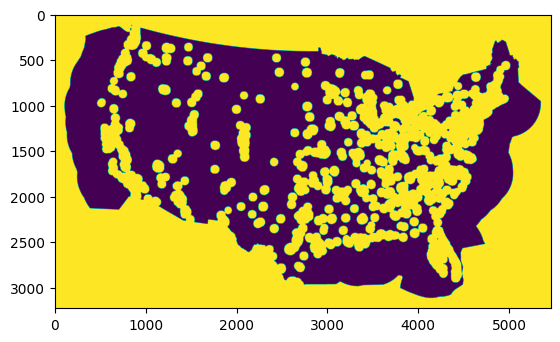

ssp5 2045


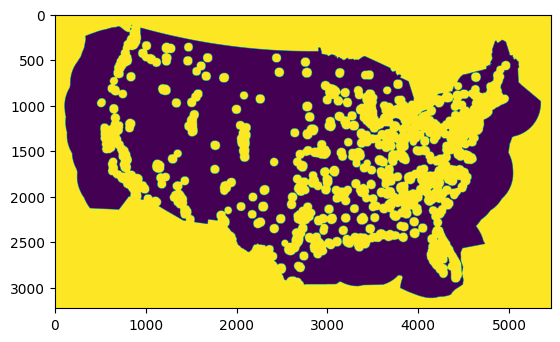

ssp5 2050


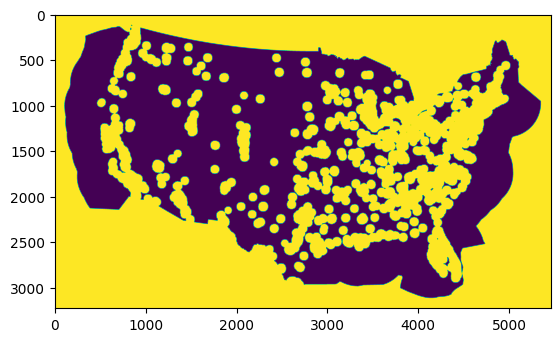

ssp5 2055


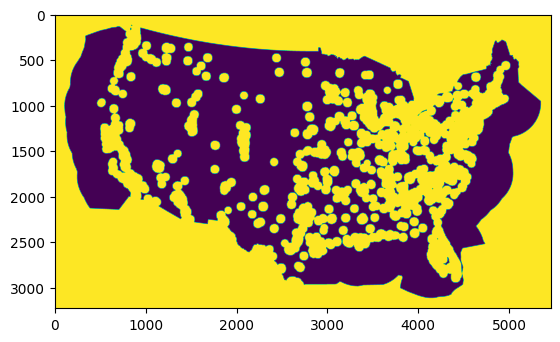

ssp5 2060


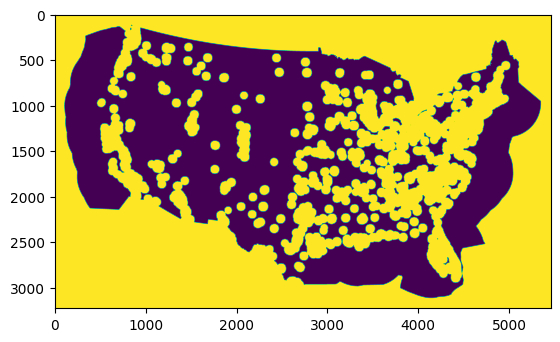

ssp5 2065


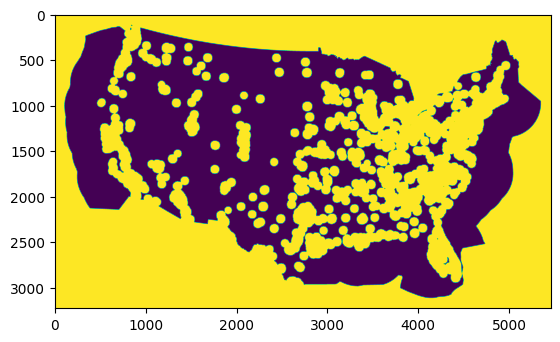

ssp5 2070


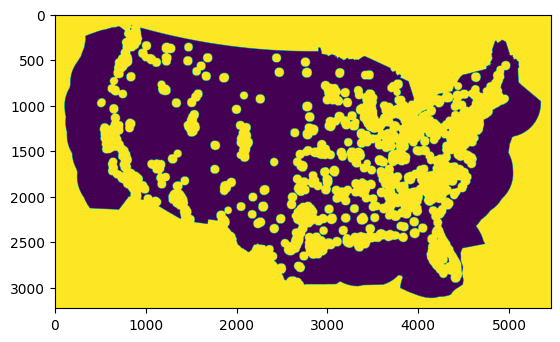

ssp5 2075


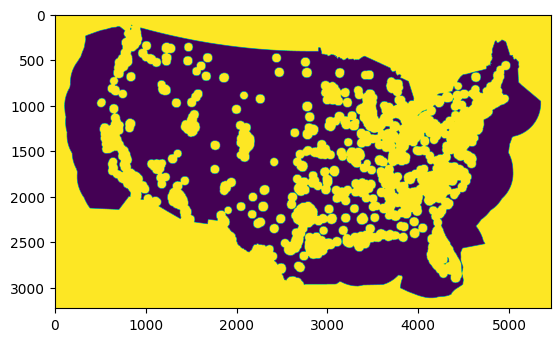

ssp5 2080


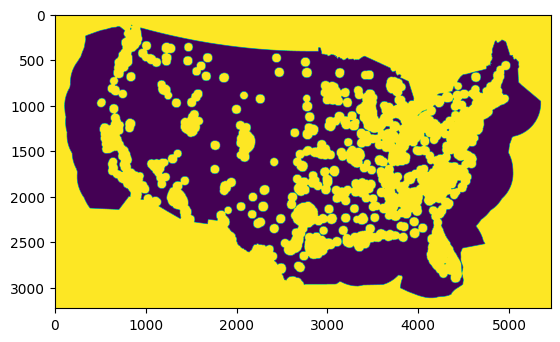

ssp5 2085


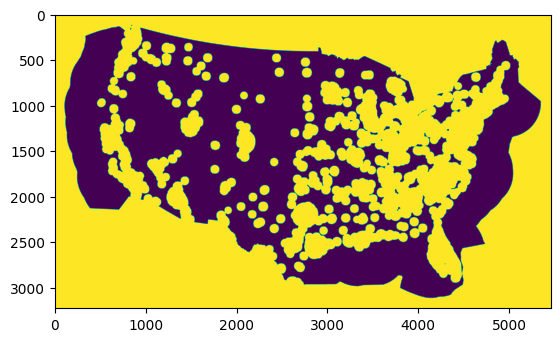

ssp5 2090


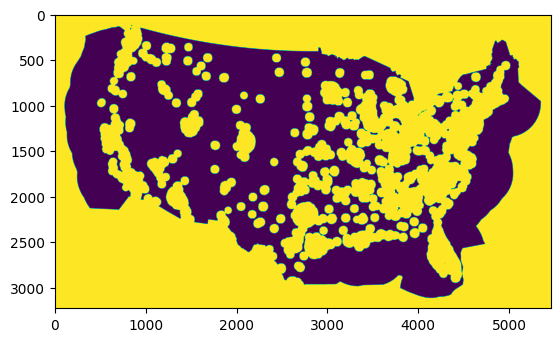

ssp5 2095


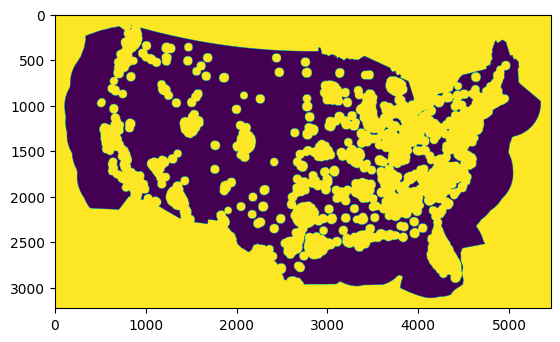

ssp5 2100


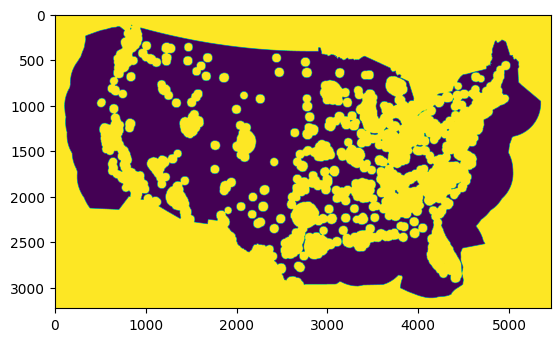

CPU times: user 1min 26s, sys: 6.73 s, total: 1min 32s
Wall time: 1min 6s


In [29]:
%%time
for ssp in ssp_list:
    for year in year_list:
        print(ssp, year)
        input_population_file = os.path.join(source_dir, 'warped', f'gridcerf_population_{ssp}_{year}_1km_conus.tif')
        # collect unbuffered file
        
        basename = os.path.splitext(os.path.basename(input_population_file))[0]
        basename += f"_{int(people_per_area/1000)}k_per{window_area}sqmi.tif"
        input_population_file = os.path.join(scenario_specific_dir, basename) 
        buffer_raster(input_raster_file=input_population_file, output_raster_dir=scenario_specific_dir, buffer_distance_mi=buffer_distance_miles)
        